In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
from torchsummary import summary
from math import log10, sqrt

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

In [4]:
model = ColorizationNet().to(device)

In [5]:
model.load_state_dict(torch.load('checkpoints/model.pth'))

<All keys matched successfully>

In [6]:
summary(model, input_size = (1, 128, 128), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,136
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [7]:
class GrayscaleImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
          img_original = self.transform(img)
          img_original = np.asarray(img_original) 
          img_lab = rgb2lab(img_original)
          img_lab = (img_lab + 128) / 255
          img_ab = img_lab[:, :, 1:3]
          img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
          img_original = rgb2gray(img_original)
          img_original = torch.from_numpy(img_original).unsqueeze(0).float()
        if self.target_transform is not None:
          target = self.target_transform(target)
        return img_original, img_ab, target

In [8]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [9]:
def to_rgb(grayscale_input, ab_input): 
    plt.clf() # clear matplotlib 
    color_image = torch.cat((grayscale_input, ab_input), dim=0).numpy() # combine channels
    color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
    color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
    color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
    color_image = lab2rgb(color_image.astype(np.float64))
    grayscale_input = grayscale_input.squeeze().numpy()
    #print(grayscale_input)
    
    fig = plt.figure(figsize=(12,10))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)
    ax = fig.add_subplot(1, 3, 1)
    ax.set_title('Input')
    ax.imshow(grayscale_input,cmap='gray')
    
    ax = fig.add_subplot(1, 3, 2)
    ax.set_title('Ground Truth')
    plt.imshow(image)
    
    ax = fig.add_subplot(1, 3, 3)
    ax.set_title('Predicted Value')
    plt.imshow(color_image)
    
    psnr_val="PSNR: "+str(PSNR(image,color_image))
    print(psnr_val)
    

In [10]:
use_gpu = torch.cuda.is_available()

In [38]:
test_transforms = transforms.Compose([transforms.Resize(224),transforms.CenterCrop(224)])
testset = GrayscaleImageFolder('dataset/test2', test_transforms)
dataloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

In [39]:
test_transforms2 = transforms.Compose([transforms.Resize(224),transforms.CenterCrop(224),
                                transforms.ToTensor()])
testset2 = datasets.ImageFolder('dataset/test2', transform=test_transforms2)
dataloader2 = torch.utils.data.DataLoader(testset2, batch_size=1, shuffle=True)
images, labels = next(iter(dataloader2))
image = images[0].numpy().transpose((1, 2, 0))

PSNR: 68.56119083608448


<Figure size 640x480 with 0 Axes>

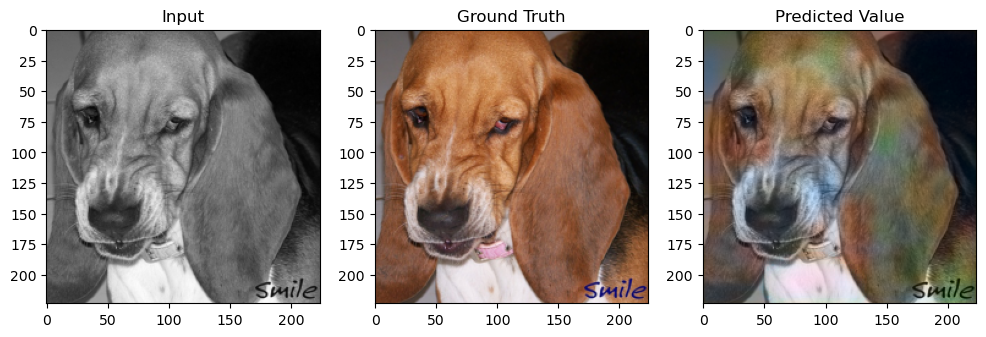

In [40]:
for i, (input_gray, input_ab, target) in enumerate(dataloader):
    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()
    # Run model and record loss
    output_ab = model(input_gray)
    for j in range(min(len(output_ab), 10)): # save at most 5 images
        to_rgb(input_gray[j].cpu(), output_ab[j].detach().cpu())
